# PR-044 MobileNet

이진원 님의 [MobileNet 강의](https://www.youtube.com/watch?v=7UoOFKcyIvM&index=45&list=PLlMkM4tgfjnJhhd4wn5aj8fVTYJwIpWkS) 감사드립니다.

MobileNet을 통해 cifar10 데이터를 학습시켜 보겠습니다.

논문: https://arxiv.org/abs/1704.04861

### Prerequisite

<code> pip install opencv-python</code>

<code> pip install scikit-learn</code>

### Data Set
케라스에서는 손쉽게 CIFAR-10 데이터를 쓸 수 있도록 api를 제공해 줍니다.

또한 [data generator](https://keras.io/preprocessing/image/)를 이용하여 augmentation을 쉽게 사용할 수 있습니다.

In [1]:
import numpy as np

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalization
x_train = np.array(x_train) / 127.5 - 1
x_test = np.array(x_test) / 127.5 - 1

# one-hot encoding
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# train data의 1/4을 validation set으로 활용합니다.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Build Model

모바일 넷 전체 구조입니다.

![image.png](mobilenet.png)

위 전체 구조에서의 conv, dw_conv 는 아래와 같은 형태입니다.
![image.png](set.png)

가장 먼저 depthwise convolution 을 만들어야 합니다.

케라스에서 사용 가능한 seperable conv2d 는 depthwise convolution 이후 pointwise convolution 까지 수행해 주는

일종의 xception 용 통합 솔루션 입니다.

모바일 넷에서는 depthwise conv 와 pointwise conv 사이에 batch norm, activation이 들어가는데

이를 위해 새로운 custom layer를 작성하겠습니다.

backend에서 제공하는 depthwise conv를 이용합니다.

In [2]:
# custom layer 의 대부분은 boilerplate 입니다.
# 미리 맞춰진 틀에 구현할 내용은 얼마 없습니다.

from keras import backend as K
from keras.engine.topology import Layer
from keras.utils.conv_utils import conv_output_length

# layer는 4-shape (batch, h, w, ch) 형태를 받습니다.
class DepthwiseConv2D(Layer):
    # hyperparameter들을 인자로 받습니다.
    def __init__(self, k_size, strides, padding, depth_multiplier, kernel_regularizer=None, **kwargs):
        self.k_size = k_size
        self.strides = strides
        self.padding = padding
        self.depth_multiplier = depth_multiplier
        self.regularizer = kernel_regularizer
        
        super(DepthwiseConv2D, self).__init__(**kwargs)

    # build 함수에서는 학습 시킬 수 있는 weight를 정의합니다.
    def build(self, input_shape):
        self.depthwise_kernel = self.add_weight(
            name='depthwise_kernel',
            shape=(self.k_size[0],
                   self.k_size[1],
                   int(input_shape[3]),
                   self.depth_multiplier),
            initializer='glorot_normal',
            regularizer=self.regularizer,
            trainable=True)
        
        super(DepthwiseConv2D, self).build(input_shape)

    # call 함수에는 실질적으로 output을 계산해내는 과정을 담습니다.
    def call(self, x):
        return K.depthwise_conv2d(x, self.depthwise_kernel,
                                  strides=self.strides,
                                  padding=self.padding,
                                  dilation_rate=(1, 1),
                                  data_format="channels_last")
                    
    # 마지막 이 함수에는 output의 크기를 정의해 줍니다. 
    def compute_output_shape(self, input_shape):
        rows = conv_output_length(input_shape[1], 
                                  self.k_size[0],
                                  self.padding,
                                  self.strides[0])
        
        cols = conv_output_length(input_shape[2], 
                                  self.k_size[1],
                                  self.padding,
                                  self.strides[1])
        
        out_filters = input_shape[3] * self.depth_multiplier

        return (input_shape[0], rows, cols, out_filters)

In [3]:
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Activation, Reshape, Input, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras import regularizers

def conv_layer_init(x, filters, stride):
    x = Conv2D(filters, (3, 3),
               strides=(stride, stride),
               padding='same',
               use_bias=False,
               kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# 1x1 conv_layer 세트
def conv_layer_1x1(x, filters):
    x = Conv2D(filters, (1, 1),
               strides=(1, 1),
               padding='same',
               use_bias=False,
               kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# 3x3 depthwise_conv_layer 세트
def conv_layer_dw(x, stride):
    x = DepthwiseConv2D((3, 3),
                        strides=(stride, stride),
                        depth_multiplier=1,
                        padding='same',
                        kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [4]:
input_img = Input(shape=(32, 32, 3))

x = conv_layer_init(input_img, 32, 2)
x = conv_layer_dw(x, 1)

x = conv_layer_1x1(x, 64)
x = conv_layer_dw(x, 2)

x = conv_layer_1x1(x, 128)
x = conv_layer_dw(x, 1)
x = conv_layer_1x1(x, 128)
x = conv_layer_dw(x, 2)

x = conv_layer_1x1(x, 256)
x = conv_layer_dw(x, 1)
x = conv_layer_1x1(x, 256)
x = conv_layer_dw(x, 2)

for i in range(5):
    x = conv_layer_1x1(x, 512)
    x = conv_layer_dw(x, 1)
x = conv_layer_1x1(x, 512)
x = conv_layer_dw(x, 2)

x = conv_layer_1x1(x, 1024)
x = conv_layer_dw(x, 1)
x = conv_layer_1x1(x, 1024)

x = GlobalAveragePooling2D()(x)
x = Reshape((1, 1, 1024))(x)
x = Dropout(0.5)(x)
x = Conv2D(10, (1, 1), padding='same')(x)
x = Activation('softmax')(x)
x = Reshape((10,))(x)

model = Model(input_img, x)

### Train Model

In [5]:
# callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import math

def lr_schedule(epoch):
    return max(1e-4, 1e-3 * math.pow(0.7, epoch // 5))

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint(filepath='model_{epoch:02d}.h5', 
                             save_best_only=True, 
                             save_weights_only=True)

In [7]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(0.0), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                              steps_per_epoch=x_train.shape[0] // 32,
                              validation_data=datagen.flow(x_val, y_val, batch_size=8),
                              validation_steps=x_val.shape[0] // 8,
                              epochs = 100,
                              callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/100
1250/1250 [==============================] - 30s 24ms/step - loss: 28.0865 - acc: 0.2085 - val_loss: 13.0324 - val_acc: 0.2861
Epoch 2/100
1250/1250 [==============================] - 28s 22ms/step - loss: 8.3813 - acc: 0.3004 - val_loss: 5.4965 - val_acc: 0.3082
Epoch 3/100
1250/1250 [==============================] - 28s 22ms/step - loss: 4.3881 - acc: 0.3302 - val_loss: 3.6756 - val_acc: 0.3201
Epoch 4/100
1250/1250 [==============================] - 28s 22ms/step - loss: 3.0486 - acc: 0.3632 - val_loss: 2.6188 - val_acc: 0.3808
Epoch 5/100
1250/1250 [==============================] - 27s 22ms/step - loss: 2.3394 - acc: 0.4176 - val_loss: 2.1059 - val_acc: 0.4504
Epoch 6/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.9424 - acc: 0.4831 - val_loss: 1.9442 - val_acc: 0.4588
Epoch 7/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.7870 - acc: 0.5167 - val_loss: 1.7398 - val_acc: 0.5318
Epoch 8/100
1250/1250 [================

1250/1250 [==============================] - 28s 22ms/step - loss: 0.7516 - acc: 0.7952 - val_loss: 0.7895 - val_acc: 0.7874
Epoch 61/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.7415 - acc: 0.7978 - val_loss: 0.8099 - val_acc: 0.7749
Epoch 62/100
1250/1250 [==============================] - 27s 22ms/step - loss: 0.7470 - acc: 0.7954 - val_loss: 0.7988 - val_acc: 0.7797
Epoch 63/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.7407 - acc: 0.7980 - val_loss: 0.7765 - val_acc: 0.7873
Epoch 64/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.7375 - acc: 0.7973 - val_loss: 0.7863 - val_acc: 0.7815
Epoch 65/100
1250/1250 [==============================] - 28s 22ms/step - loss: 0.7297 - acc: 0.8008 - val_loss: 0.8012 - val_acc: 0.7809
Epoch 66/100
1250/1250 [==============================] - 27s 22ms/step - loss: 0.7245 - acc: 0.8001 - val_loss: 0.7790 - val_acc: 0.7863
Epoch 67/100
1250/1250 [=======================

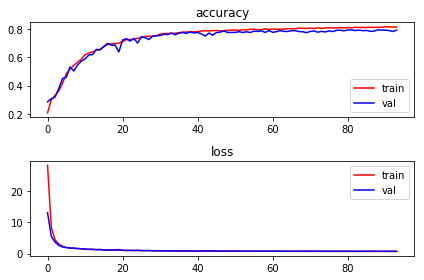

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Evaluate Model

In [10]:
score = model.evaluate(x_test, y_test)

print('test score:', score[0])
print('test accuracy:', score[1])

10000/10000 [==============================] - 1s 132us/step
test score: 0.6452600821495056
test accuracy: 0.8242


### Tip!

[keras application](https://keras.io/applications/#mobilenet)의 mobilenet을 사용하면 매우 편리하게 imagenet으로 학습된 모델을 가져올 수 있습니다.

In [11]:
from keras.applications import mobilenet

model = mobilenet.MobileNet()

17227776/17225924 [==============================] - 14s 1us/step


## Contact me
케라스를 사랑하는 개발자 입니다.

질문, 조언, contribtuion 등 소통은 언제나 환영합니다.

Anthony Kim(김동현) : artit.anthony@gmail.com